In [116]:
import matplotlib.pyplot as plt
import pandas as pd
import os
from matplotlib.ticker import FormatStrFormatter

In [117]:
def extract_variation(row):
    experiment_name = row['ExperimentName']
    names = experiment_name.split(" | ")
    extracted_variations = []

    for name in names:
        variation = name.split("=")[-1]
        extracted_variations.append(variation)
    return " | ".join(extracted_variations)

def extract_parameter_order(row):
    experiment_name = row['ExperimentName']
    names = experiment_name.split(" | ")
    extracted_parameters = []

    for name in names:
        parameter = name.split("=")[0]
        extracted_parameters.append(parameter)
    return " | ".join(extracted_parameters)


def get_last_items(log_file: str) -> pd.DataFrame:
    df = pd.read_csv(log_file)
    experiments = df['ExperimentName'].drop_duplicates()
    last_item_frames = [df[df['ExperimentName'] == experiment].iloc[[-1]] for experiment in experiments]
    last_items = pd.concat(last_item_frames)
    last_items['Variation'] = last_items.apply(extract_variation, axis=1)
    last_items.insert(0, 'New_Numbering', range(len(last_items)))
    return last_items

def plot_log_dir(log_dir: str, baseline_name="baseline", highlight=3):
    log_files = [f"{log_dir}/{file}" for file in os.listdir(log_dir)]

    def plot_fitness():
        baseline_mean = 0.1
        if default := [log for log in log_files if f"trace-{baseline_name}.csv" in log]:
            default = default[0]
            log_files.remove(default)
            baseline_mean = get_last_items(default).loc[:, 'AveBestFitness'].mean()

        frames = [get_last_items(log_file) for log_file in log_files]

        fig, axs = plt.subplots(1, len(frames), figsize=(max(5*len(frames),10), 8), sharey=True, layout='constrained')
        for df, log_file, ax in zip(frames, log_files, axs):
            ax.plot(df['New_Numbering'], df['AveBestFitness'], 'o-', label="Experiments")
            # Highlight our 3 minimum values
            smallest = df.nsmallest(highlight, "AveBestFitness")
            ax.plot(smallest['New_Numbering'], smallest['AveBestFitness'], 'o', label=f"Lowest {highlight}")

                # General formatting for the plot
            ax.set_title(log_file.split("/trace-")[-1].removesuffix(".csv"))
            ax.set_xlabel(extract_parameter_order(df.iloc[0]))
            ax.grid(True)
            current_mean = df.loc[:, 'AveBestFitness'].mean()

            # axs.hlines(y=default_last_val, xmin=0, xmax=len(last_items)-1, color='r', label=f"Default {round(default_last_val, 4)}")
            # axs.hlines(y=combination_last_val, xmin=0, xmax=len(last_items)-1, color='g', label=f"Combination of Best {round(combination_last_val, 4)}")
            ax.hlines(y=current_mean, xmin=0, xmax=len(df)-1, color='yellow', label=f"Mean {round(current_mean,4)}")
            ax.hlines(y=baseline_mean, xmin=0, xmax=len(df)-1, color='brown', label=f"Baseline Mean {round(baseline_mean,4)}")
            ax.legend()

            ax.set_xticks(range(len(df)))
            ax.set_xticklabels(df['Variation'], rotation=90)
            for _, row in smallest.iterrows():
                ax.get_xticklabels()[row['New_Numbering']].set_color("orange")
                ax.text(row['New_Numbering']+min(.08*len(df), 1.1), row['AveBestFitness'], f"{round(row['AveBestFitness'], 4)}", ha="center", color='orange', rotation=45)

            # Format the y-axis to be log scale, but still show whole numbers, and to display ticks next to each chart
            ax.set_yscale('log')
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax.yaxis.set_tick_params(labelbottom=True)

        fig.supylabel('Fitness (=> 0)')
        plt.show()

    def plot_convergence():
        convergence_mean = 0.1

        if default := [log for log in log_files if f"trace-{baseline_name}.csv" in log]:
            default = default[0]
            log_files.remove(default)
            convergence_mean = get_last_items(default).loc[:, 'Convergence'].mean()

        frames = [get_last_items(log_file) for log_file in log_files]

        fig, axs = plt.subplots(1, len(frames), figsize=(max(5*len(frames),10), 8), sharey=True, layout='constrained')
        for df, log_file, ax in zip(frames, log_files, axs):
            ax.plot(df['New_Numbering'], df['Convergence'], 'o-', label="Experiments")

            ax.set_title(log_file.split("/trace-")[-1].removesuffix(".csv"))
            ax.set_xlabel(extract_parameter_order(df.iloc[0]))
            ax.grid(True)
            current_mean = df.loc[:, 'Convergence'].mean()

            ax.hlines(y=current_mean, xmin=0, xmax=len(df)-1, color='yellow', label=f"Mean {round(current_mean,4)}")
            ax.hlines(y=convergence_mean, xmin=0, xmax=len(df)-1, color='brown', label=f"Baseline Mean {round(convergence_mean,4)}")
            ax.legend()

            ax.set_xticks(range(len(df)))
            ax.set_xticklabels(df['Variation'], rotation=90)

            # Format the y-axis to be log scale, but still show whole numbers, and to display ticks next to each chart
            ax.set_yscale('log')
            # ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax.yaxis.set_tick_params(labelbottom=True)

        fig.supylabel('Fitness (=> 0)')
        plt.show()

    plot_fitness()

    log_files = [f"{log_dir}/{file}" for file in os.listdir(log_dir)]
    plot_convergence()




# Analysis

$$v_{ij}(t + 1) = w * v_{ij}(t) + c_{1}r_{1j}(t)[y_{ij}(t) − x_{ij}(t)]
                + c_{2}r_{2j}(t)[\hat{y}_{j}(t) − x_{ij}(t)] $$


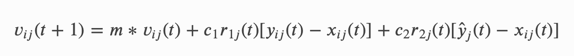

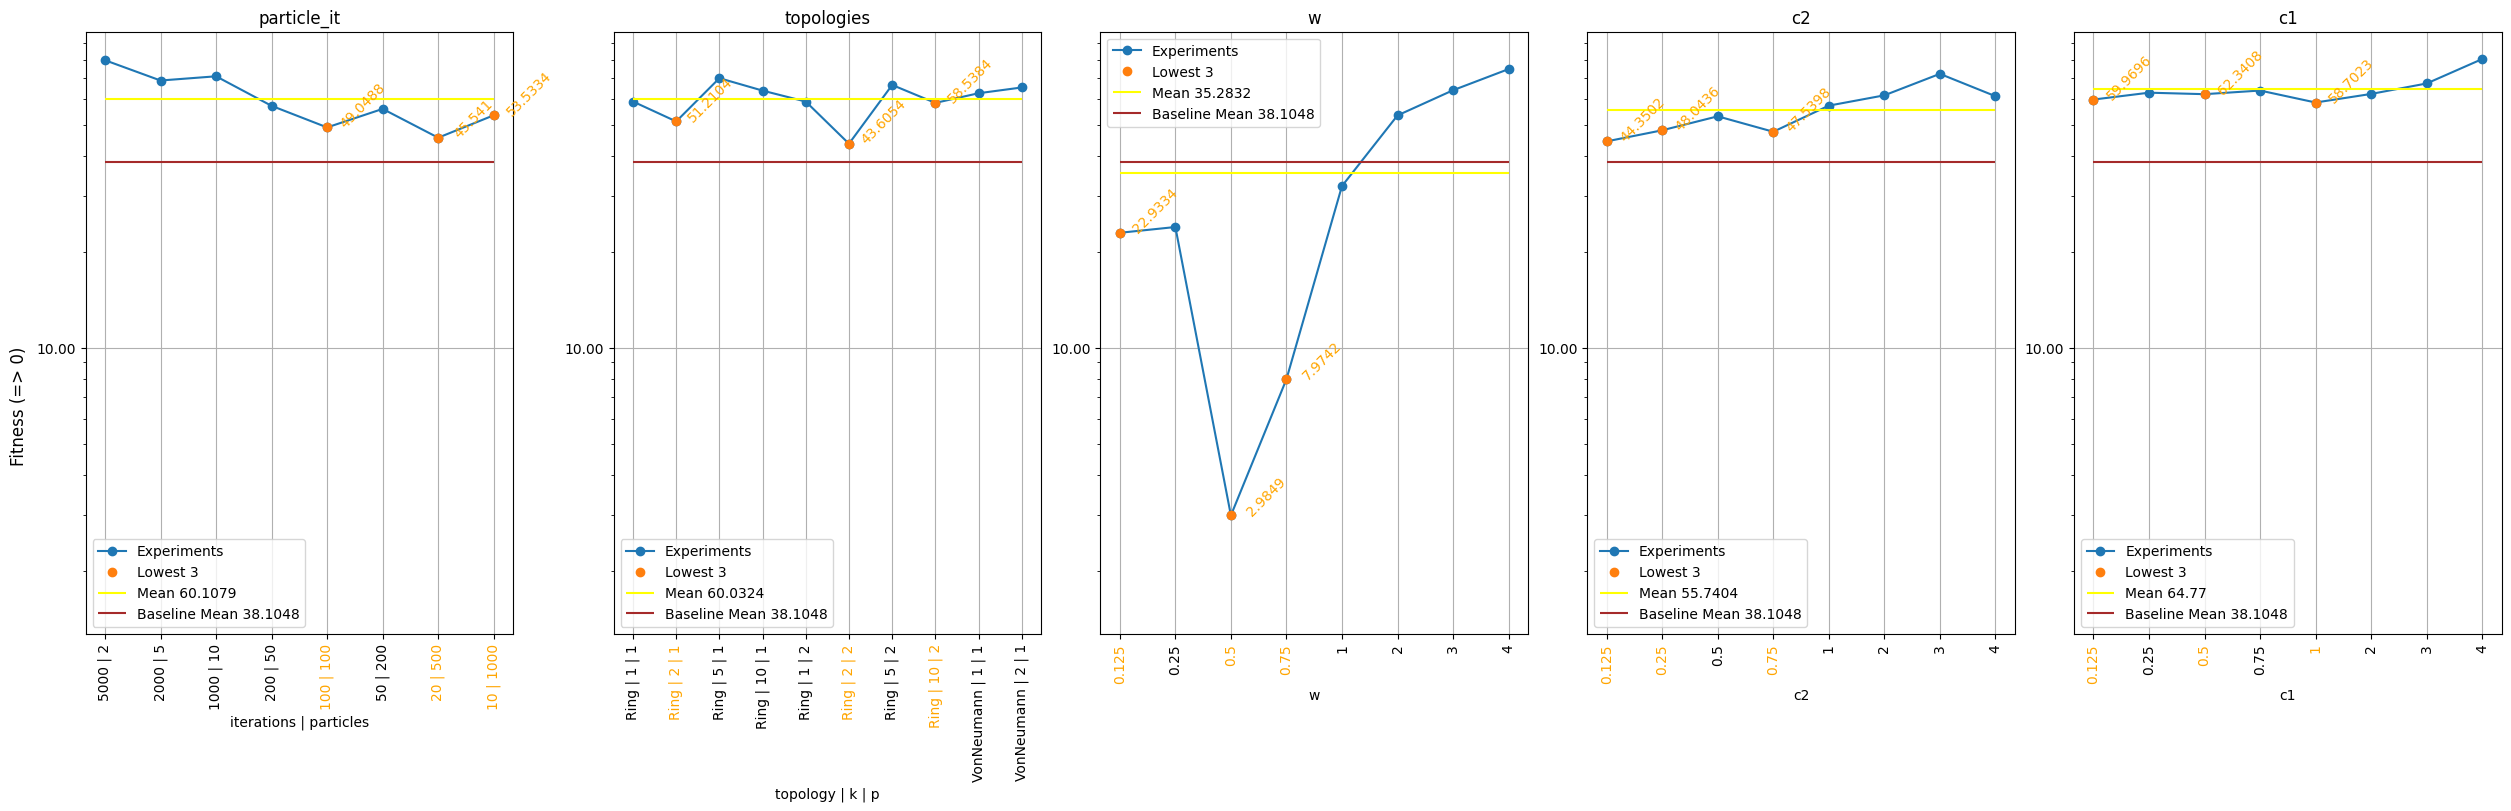

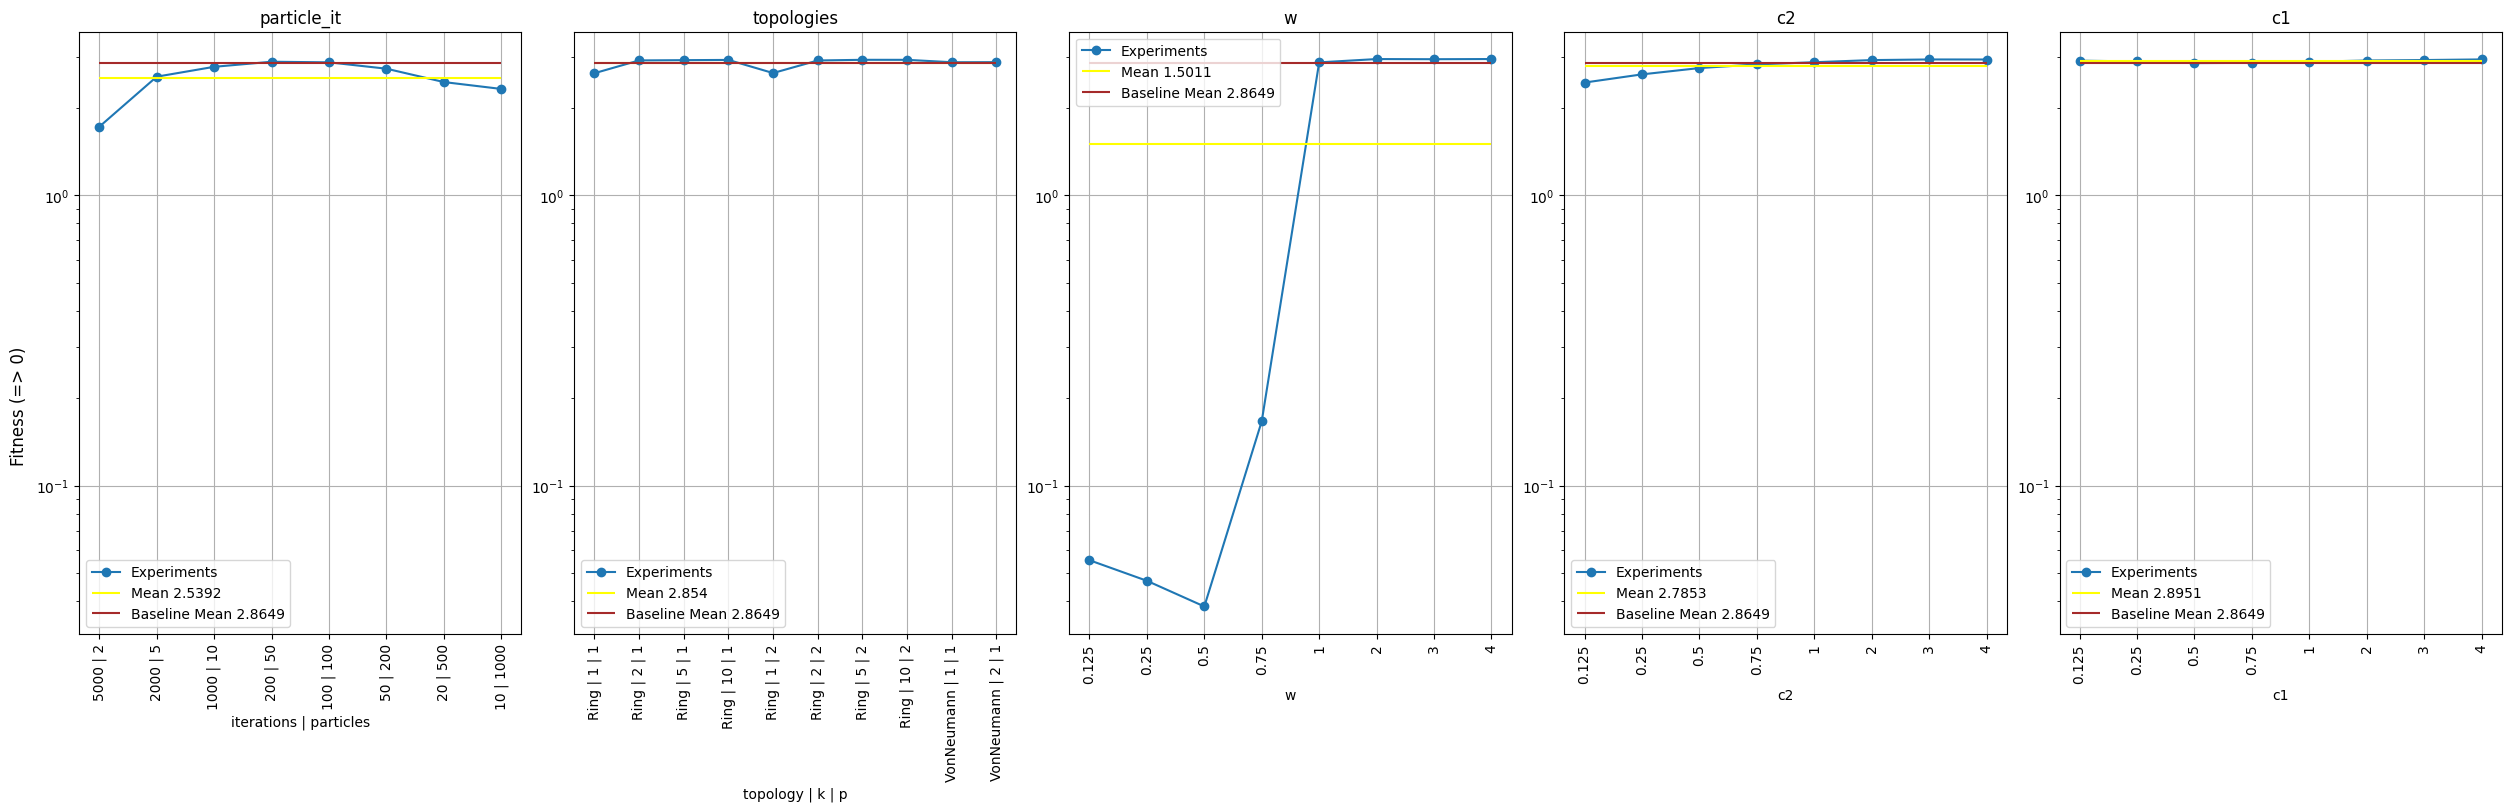

In [118]:
plot_log_dir("PSO_Logs_Initial_Run")


# Analysis

Following the above results, we can see that for one, the convergence numbers stay roughly the same for all of our parameter runs, aside from w our intertia weight. I believe this means that due to us having too high of a interia to start off with, our solutions have lots of difficulties converging to a optimal solution. Following this logic, we can also see that this is well represented in the lowest fitness value, were lower values of w strongly outperform all other experiments so far.

Due to us not being able to determine a strong improvement in the other experiments, I will nor yet run combinatory sweeps, but instead I will simply fix the baseline value of w to sweep other variables more efficiently.
The two best values for w are currently 0.5 and 0.75, with results of 2.98 and 7.98 respectively. Although 0.5 performs a significant amount better I will nevertheless fix the value at 0.75. My reasoning for this is that I want to avoid strying too low as this may cause too early convergence. Additionally, reasing best practices for PSO it is noted that for Continuous Optimisation problems a higher interia weight is recommended, therefore I will fix the value at 0.75 for now, although I will keep in mind to retest other w value combinations at a later date.

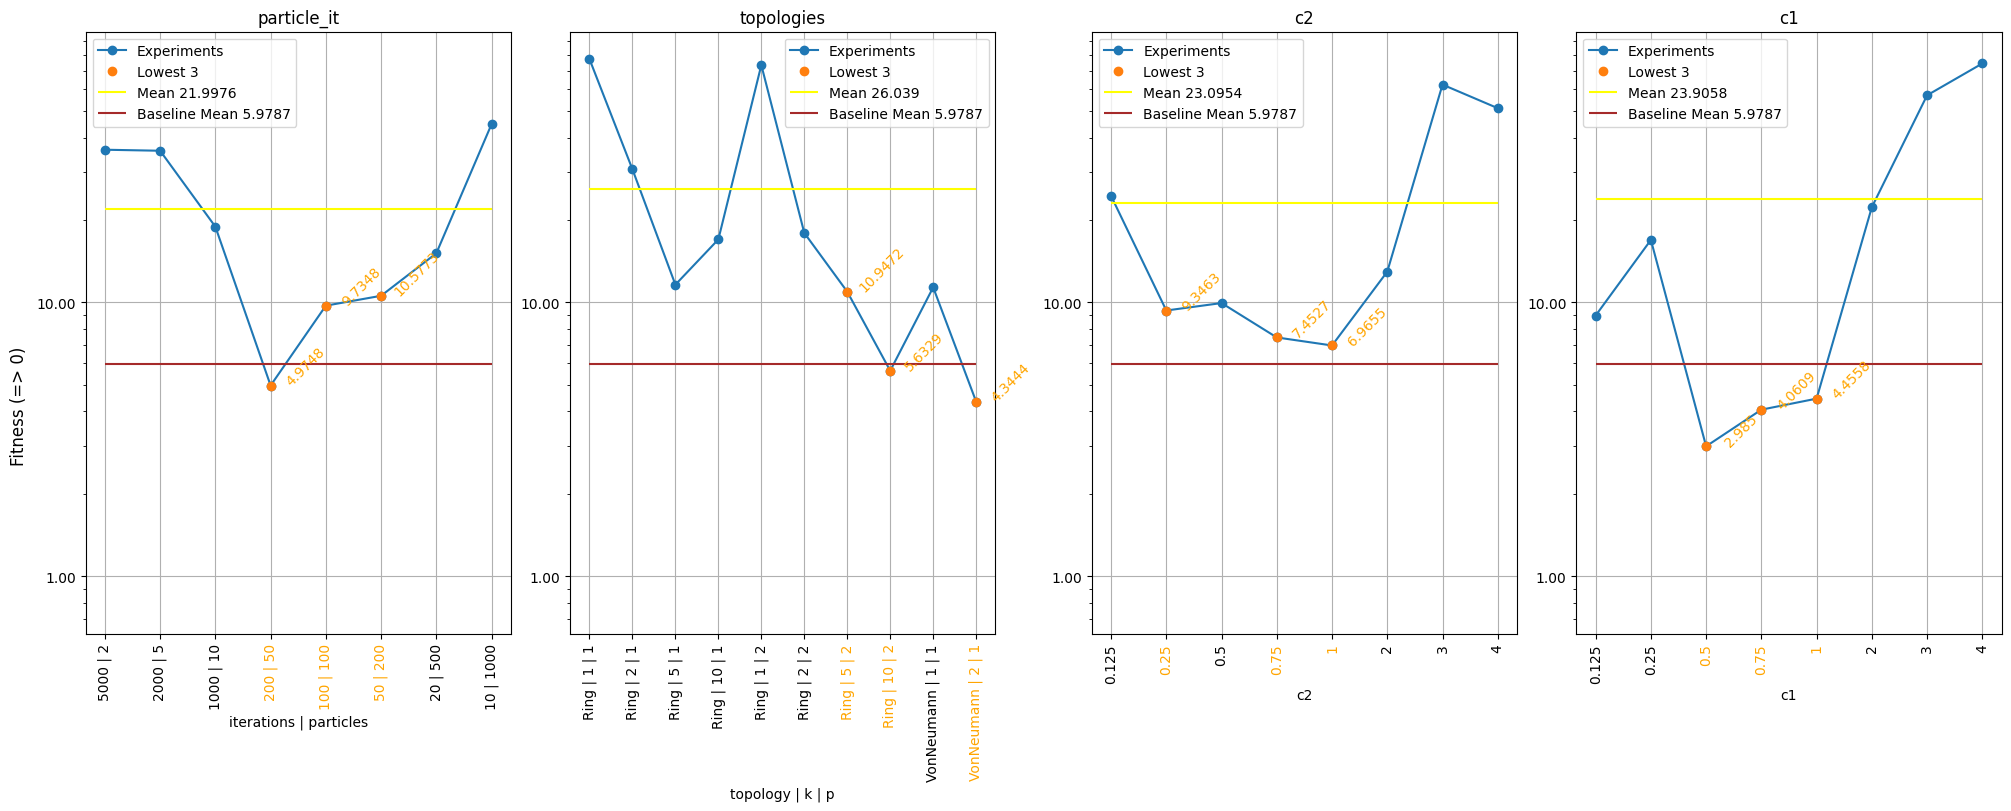

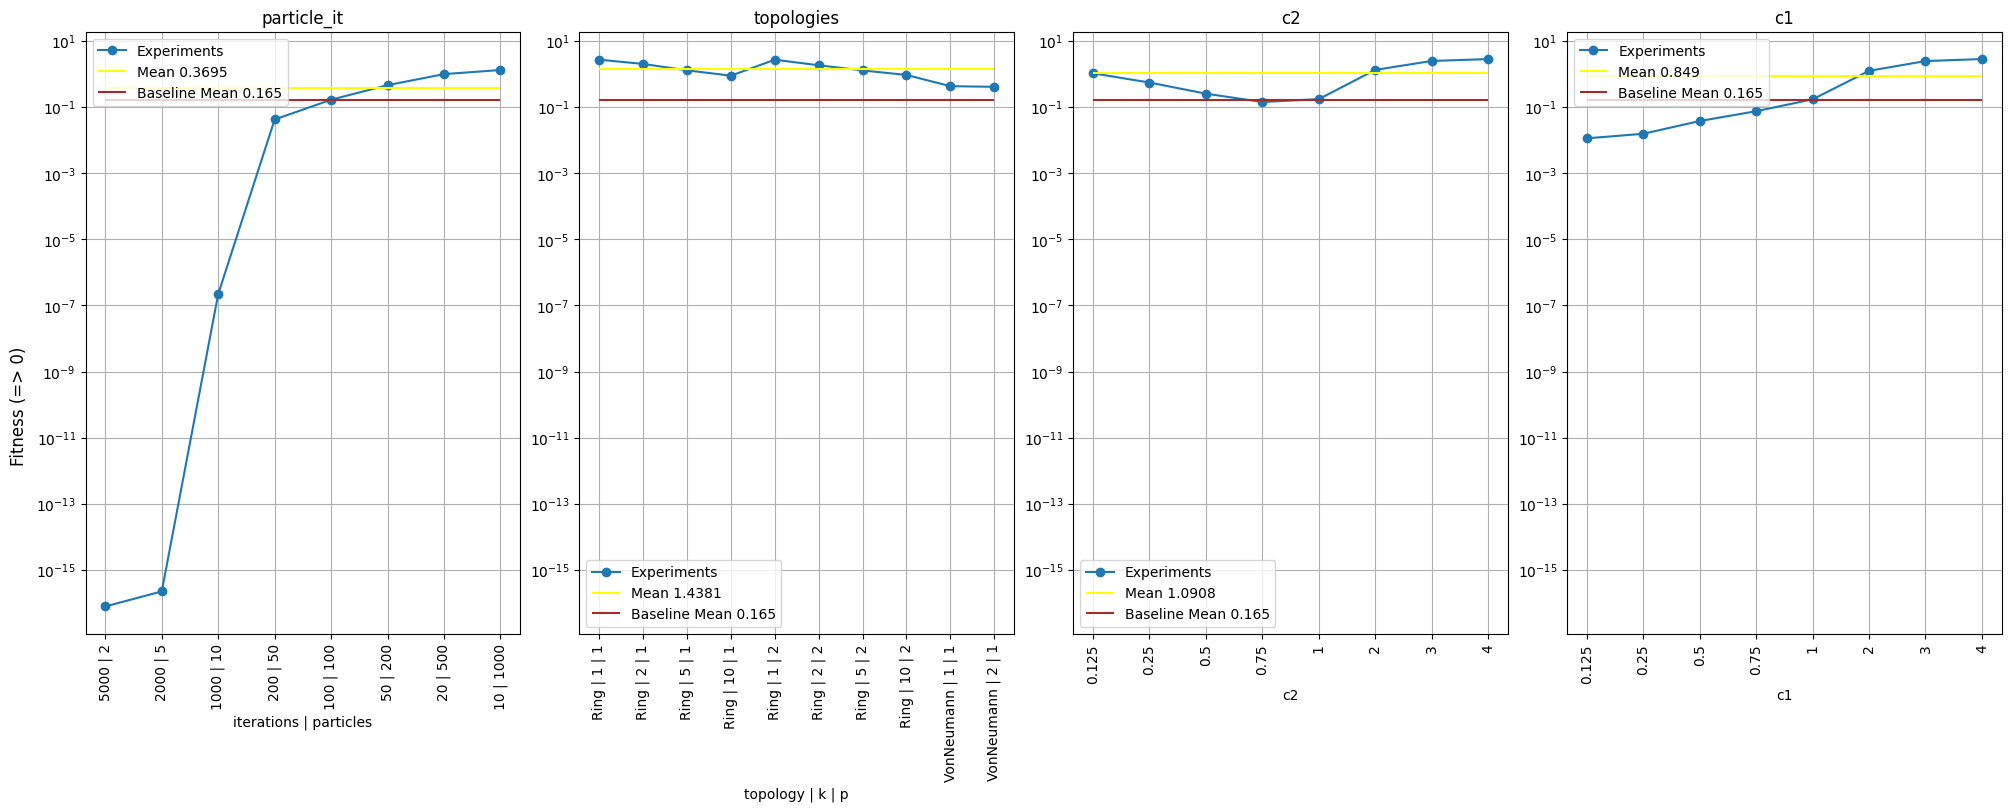

In [119]:
plot_log_dir("PSO_Logs_fixed_w")

# Analysis

Now looking at the results, one thing that immediately pops out to me is the strong convergence for values 5000/2 2000/5, 1000/10 for iteration/particle combinations. In addition to this a degradation in performance for those values tells me that the decreased intertia weight and the low amount of particles leads to an immense convergence, to the point where exploration barely happens anymore. Now since we have determined that for all values of w on or above 1 lead to fitness values of 30-50, I can not justify setting w at a massively higher value than what we have currently set. Due to that reasoning, I feel it reasonable to remove the above-mentioned iteration/particle combinations from future testing.

Here we cannot truely determine which parameters are better than other especially when we also want to consider combinations of parameters that could be better than others. Considering that I can see that both constants values c1 and c2 correlate strongly with eachother, setting both higher will increase convergence and lowering both will decrease it. When only one of the two is increased we see convergences at different points, for c1 this will be at the local optimum and for c2 all will converge at the global optimum. Either way setting them too high can lead to too low exploration of new fields. For that reason I want to sweep across all 8x8 combinations of the parameters to determine which combinations work best for this problem. I will then visualise the findings using a heatmap.

I will do the same for iterations/particles and the topology. Maybe having a high amount of particles with small neighbourhoods could be advantagous. Being that I do not know yet, I will run sweeps of their combinations too and plot the findings on a heatmap as well.
For this we will do 5x10 runs. Following a bit of testing the VonNeumann topology doesn't seem to work very well with exceptions at different combinations, therefore I will be excluding them from future tests, leaving me with 5x8 runs.

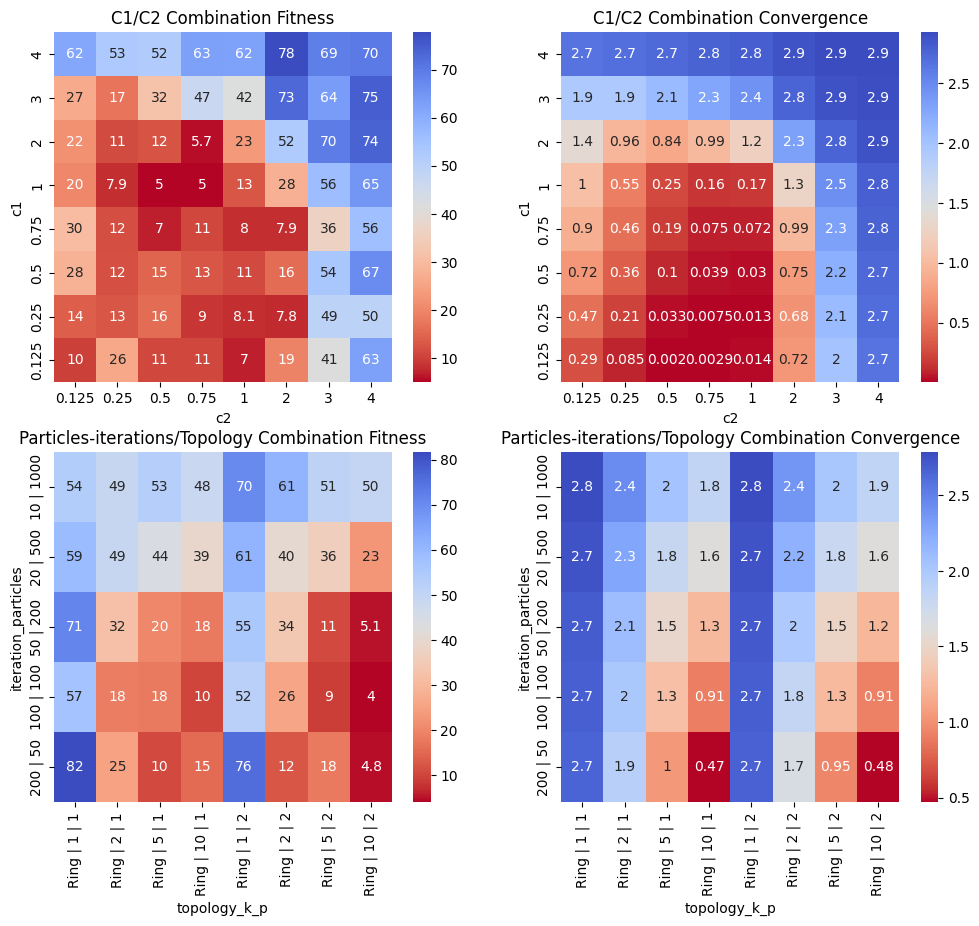

In [146]:
import seaborn as sns

def get_param(param: str):
    def param_getter(row):
        experiment_name = row['ExperimentName']
        names = experiment_name.split(" | ")
        for name in names:
            if param in name:
                return name.split('=')[-1]
        return "undefined"
    return param_getter

df = get_last_items("PSO_Logs_2D_Sweeps/trace-c1-c2.csv")
df['c1'] = df.apply(get_param('c1'), axis=1)
df['c2'] = df.apply(get_param('c2'), axis=1)
df = df.drop(columns=['New_Numbering', 'It', 'Variation', 'ExperimentName'])
c1c2_df_fitness_pivot = df.pivot_table(index='c1', columns='c2', values='AveBestFitness', aggfunc='mean').sort_index(ascending=False)
c1c2_df_convergence_pivot = df.pivot_table(index='c1', columns='c2', values='Convergence', aggfunc='mean').sort_index(ascending=False)

df = get_last_items("PSO_Logs_2D_Sweeps/trace-particle_it-topology.csv")
df['particles'] = df.apply(get_param('particles'), axis=1)
df['iterations'] = df.apply(get_param('iterations'), axis=1)
df['topology'] = df.apply(get_param('name'), axis=1)
df['k'] = df.apply(get_param('k'), axis=1)
df['p'] = df.apply(get_param('p'), axis=1)

df["iteration_particles"] = df["iterations"].astype(str) + " | "+ df["particles"].astype(str)
df["topology_k_p"] = df["topology"].astype(str) + " | " + df["k"].astype(str) + " | " + df["p"].astype(str)
df = df.drop(columns=['New_Numbering', 'It', 'Variation', 'ExperimentName', 'particles', 'iterations', 'topology', 'k', 'p'])

pit_df_fitness_pivot = df.pivot_table(index='iteration_particles', columns='topology_k_p', values='AveBestFitness', aggfunc='mean')
pit_df_convergence_pivot = df.pivot_table(index='iteration_particles', columns='topology_k_p', values='Convergence', aggfunc='mean')
row_order = ['10 | 1000', '20 | 500', '50 | 200', '100 | 100',  '200 | 50']
column_order = ['Ring | 1 | 1', 'Ring | 2 | 1', 'Ring | 5 | 1', 'Ring | 10 | 1', 'Ring | 1 | 2', 'Ring | 2 | 2', 'Ring | 5 | 2', 'Ring | 10 | 2']
pit_df_fitness_pivot = pit_df_fitness_pivot.reindex(row_order, axis=0).reindex(column_order, axis=1)
pit_df_convergence_pivot = pit_df_convergence_pivot.reindex(row_order, axis=0).reindex(column_order, axis=1)


fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(12, 10)
)

axs[0,0].set_title("C1/C2 Combination Fitness")
axs[0,1].set_title("C1/C2 Combination Convergence")
axs[1,0].set_title("Particles-iterations/Topology Combination Fitness")
axs[1,1].set_title("Particles-iterations/Topology Combination Convergence")

sns.heatmap(c1c2_df_fitness_pivot, annot=True, cmap='coolwarm_r', ax=axs[0,0])
sns.heatmap(c1c2_df_convergence_pivot, annot=True, cmap='coolwarm_r', ax=axs[0, 1])
sns.heatmap(pit_df_fitness_pivot, annot=True, cmap='coolwarm_r', ax=axs[1,0])
sns.heatmap(pit_df_convergence_pivot, annot=True, cmap='coolwarm_r', ax=axs[1, 1])

plt.show()

# Analysis

Okay, now from these experiments we can find a few interesting things:
1. A strong convergence does not indicate a good fintess value. We can see that for iteration-particle = 200|50 and Ring | 10 | 1&2 we see that one has a vastly better result than the other even though their convergence numbers are basically the same. We also see the same when examining the c1/c2 plots, where the convergence rate does not sit on the same combinations as the best fitness.
2. We can also see that for all experiments wehre we had <=20 iterations and greater than or  >=500 particles, ie. 20 | 500 and 10 | 1000 we have both a poor fitness value and little convergence. I take this to mean that we don't have enough time to converge the particles at a good solution, and in fact those results depend strongly on the random initial placement of the particles for a good result.
3. Having a ring size of 1, no matter if we use manhattan distance or Euclidean distance leads to vastly poorer results than the alternatives
4. Having either c1 or c2 >= 3 leads to poorer results, I believe this due to the lack of exploration for our values
5. On general aside from when c1 or c2 >= 3, having c1 > c2 leads to better results than c2 >= c1. We see this with our optimal values where they each lie at c2=(0.5, 0.75) and c1=(0.75, 1, 2)

Based on points 2-5 what I will do for the next experiments is as follows:
1. I will again use heatmaps to visualise data as these trends pop out nicely and are easy to evaluate
2. I will not use ring sizes of 1
3. I will not use particle sizes of >= 500 and iterations counts of <= 20
4. I will not use values of c1 and c2 of >= 3
5. I will use higher ranges of values of c1 than c2, combinations will still explore c1 <= c2 but in general c1 will hold higher values than c2




